# Use pretrained resnet18 in CIFAR10

In [23]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms,models
import torchvision as tv
from tqdm import tqdm
import matplotlib.pyplot as plt

### Extract,Transform and Load into dataloaders

In [32]:
tfms = transforms.Compose([transforms.ToTensor()])
                          #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [33]:
trainset = datasets.CIFAR10('./data',train=True,transform=tfms,download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

testset = datasets.CIFAR10('./data',train=False,transform=tfms,download=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
classes = trainloader.dataset.classes;classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [35]:
trainloader.dataset[0][0].shape

torch.Size([3, 32, 32])

automobile   dog  ship   dog  frog   cat  ship airplane airplane airplane horse  ship  bird automobile  frog  frog  bird airplane  deer horse automobile   cat airplane  ship airplane  bird  deer horse airplane  frog   cat airplane   cat  frog  bird automobile   dog horse  bird automobile   cat  frog  frog truck  frog   cat  bird horse horse airplane  deer truck  deer horse  ship  frog  bird  bird airplane  ship horse automobile  bird  deer


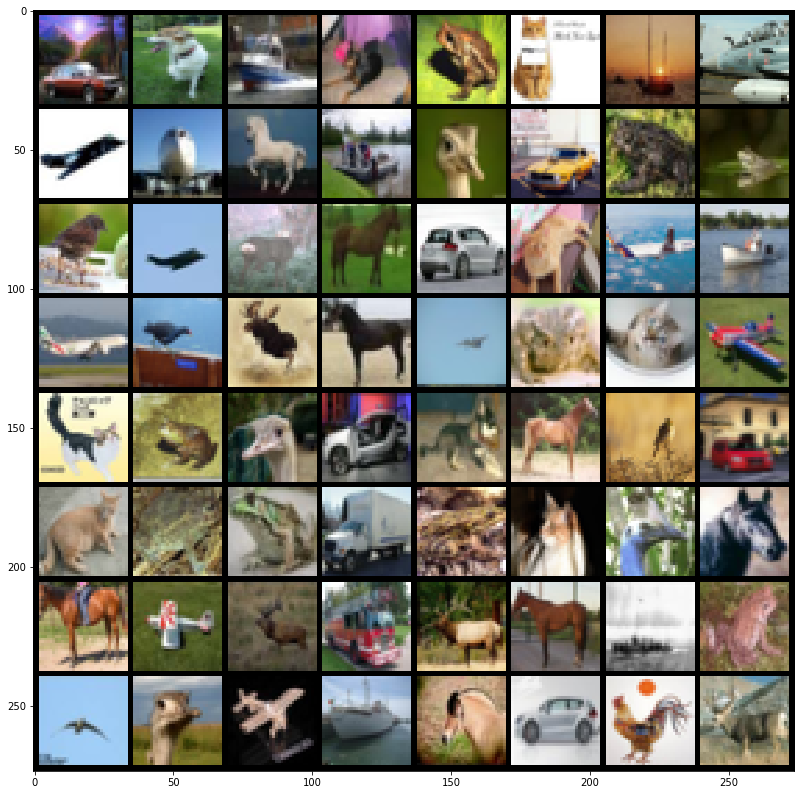

In [54]:
batch=next(iter(trainloader))
img,label=batch

imgs=tv.utils.make_grid(img)
print(' '.join('%5s' % classes[label[j]] for j in range(64)))
plt.figure(figsize=(14,14))
plt.imshow(imgs.permute(1,2,0))

In [62]:
net = models.resnet18(pretrained=True)
torch.save(net.state_dict(),'pre_trained_dict.pt')

In [64]:
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [67]:
net.load_state_dict(torch.load('pre_trained_dict.pt'),strict=False)
#for some reason It returns a missmatching error even tho Strict is set to false

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([1000, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([10]).

In [65]:
net.layer1[0].conv1.weight.sum()

tensor(-113.8010, grad_fn=<SumBackward0>)

In [68]:
for param in net.parameters():
    param.requires_grad = False
net.fc.weight.requires_grad=True
net.fc.bias.requires_grad=True

In [70]:
net.layer2[1].bn1.weight.requires_grad

False

In [72]:
net.eval();

In [79]:
def learn(net,epochs,dataloader,testloader,lr):
    losses =[]
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(filter(lambda p:p.requires_grad,net.parameters()),lr,momentum=0.9)
    for epoch in range(epochs):
        for d,batch in enumerate(dataloader):
            optimizer.zero_grad()
            img,label = batch
            output = net(img)
            loss = loss_fn(output,label)
            loss.backward()
            losses.append([epoch,d,loss.item()])
            optimizer.step()
        correct=0
        total=0
        with torch.no_grad():
            for m in testloader:
                X,y = m
                predict = net(X)
                for idx,i in enumerate(predict):
                    if torch.argmax(i)==y[idx]:
                        correct+=1
                    total+=1
        print('epoch:{} loss:{} accuracy {}'.format(epoch,loss.item(),round(correct/total*100,3)))
    return losses

In [83]:
losses = learn(net,10,trainloader,testloader,1e-3)

epoch:0 loss:0.9442179799079895 accuracy 61.2
epoch:1 loss:0.5876303315162659 accuracy 61.1
epoch:2 loss:0.9552519917488098 accuracy 61.26
epoch:3 loss:1.1015266180038452 accuracy 60.97
epoch:4 loss:0.9541862607002258 accuracy 61.13
epoch:5 loss:1.0970889329910278 accuracy 61.24
epoch:6 loss:0.7280113697052002 accuracy 61.28
epoch:7 loss:0.9785951972007751 accuracy 61.17
epoch:8 loss:1.5400749444961548 accuracy 61.2
epoch:9 loss:1.0015554428100586 accuracy 61.24


In [92]:
loss = torch.tensor(losses)

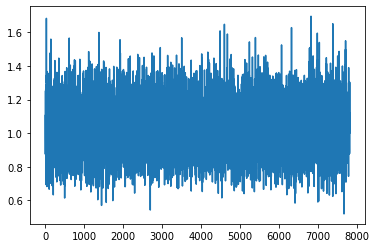

In [95]:
plt.plot(loss[:,2])